### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [100]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 20        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500  # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [16]:
# Constants: 

In [17]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [18]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [19]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [20]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [21]:
# for testing:

In [22]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [23]:
φ

array([0.48872295, 0.25198128, 0.03001846, 0.94182748, 0.17714483,
       0.30744101, 0.87924607, 0.77175731, 0.54323011, 0.62997081,
       0.415102  , 0.59952791, 0.88752377, 0.95077901, 0.0310507 ,
       0.83274619, 0.36783991, 0.64818768, 0.6071106 , 0.73718611])

In [24]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [25]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [26]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [27]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [28]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [29]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [30]:
Π(φ,θ,ψ)

array([[[ 0.86276694,  0.        ,  0.44641261],
        [ 0.        ,  1.        , -0.46949872],
        [-0.50560182,  0.        ,  0.76176554]],

       [[ 0.91653204,  0.        ,  0.38733063],
        [ 0.        ,  1.        , -0.24932316],
        [-0.39996127,  0.        ,  0.88758828]],

       [[ 0.99803609,  0.        ,  0.06261331],
        [ 0.        ,  1.        , -0.03001396],
        [-0.06264153,  0.        ,  0.99758646]],

       [[ 0.99818453,  0.        ,  0.03543399],
        [ 0.        ,  1.        , -0.80863458],
        [-0.06023001,  0.        ,  0.58724318]],

       [[ 0.63990758,  0.        ,  0.75642625],
        [ 0.        ,  1.        , -0.1762198 ],
        [-0.76845188,  0.        ,  0.62989357]],

       [[ 0.68302522,  0.        ,  0.69614738],
        [ 0.        ,  1.        , -0.30262063],
        [-0.73039479,  0.        ,  0.65099891]],

       [[ 0.95220622,  0.        ,  0.19479903],
        [ 0.        ,  1.        , -0.77025829],
        

In [31]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [32]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 1.2078932 ,  0.51264565,  0.2359349 ],
       [ 0.8024252 ,  0.68290555,  0.58510998],
       [ 0.89767399,  0.42347096,  0.19737331],
       [ 0.55756205, -0.18125646,  0.14100679],
       [ 0.74990764,  0.45408284,  0.12215207],
       [ 1.02511442, -0.05502349,  0.28562333],
       [ 0.43011264,  0.04999161,  0.25968786],
       [ 0.92125458, -0.51408507,  0.26664126],
       [ 0.52084892,  0.09490312,  0.16594017],
       [ 0.27948859,  0.28098242,  0.59651821],
       [ 0.23938452,  0.7291215 ,  0.35674447],
       [ 0.44051857,  0.30746493,  0.13101004],
       [ 0.88226707, -0.28787728,  0.25306717],
       [ 0.25275103, -0.25568153,  0.15811469],
       [ 0.17436604,  0.94298541,  0.23139426],
       [ 0.55581058,  0.01144582, -0.18676656],
       [ 1.27356509,  0.2728341 , -0.11515951],
       [ 0.41370607,  0.06046372,  0.28816745],
       [ 0.64598279,  0.35908035,  0.51016447],
       [ 0.37763661, -0.50536422,  0.69536695]])

In [33]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [34]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.52252455,  0.39716277, -0.63133319],
       [ 1.74066209,  0.66058741,  0.09352359],
       [ 1.32659874,  0.59542838, -0.0047689 ],
       [ 1.22025639,  0.28799267,  0.19709455],
       [ 1.31601957,  1.04750374, -0.06576407],
       [ 0.79939289,  0.10527278,  0.78754969],
       [ 1.20758922,  0.21021502,  0.41037583],
       [ 1.45235838, -0.266509  ,  0.3288574 ],
       [ 1.45370953,  0.11648057,  0.101835  ],
       [ 0.942814  ,  0.36983832,  1.27361075],
       [ 1.22424703,  1.23118929,  0.84233506],
       [ 0.74181289,  0.73136276,  0.08996145],
       [ 1.69649242, -0.22499129,  0.56383176],
       [ 0.56696218,  0.88518411,  0.32034207],
       [ 1.06014302,  1.14304093,  0.02275712],
       [ 1.24718494, -0.21849574,  0.17173105],
       [ 1.68426619,  0.82593192, -0.63148753],
       [ 1.15267296,  0.51219767,  0.61044862],
       [ 1.44608375,  0.43259003,  0.54684022],
       [ 0.72912778,  0.06254478,  1.01887865]])

In [35]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [36]:
phi(x,y,z)

array([[0.23319093, 0.24366431, 0.19785414],
       [0.0036918 , 0.52551234, 0.06259216],
       [0.50098367, 0.88737703, 0.44529728],
       [0.02188972, 0.39875034, 0.0179097 ],
       [0.82071117, 0.42130061, 0.75290274],
       [0.01943091, 0.24620755, 0.09254503],
       [0.9162076 , 0.91371907, 0.22810414],
       [0.75413989, 0.97609727, 0.37705301],
       [0.53238388, 0.1984537 , 0.54260653],
       [0.04534761, 0.85105881, 0.20843442],
       [0.28820297, 0.71661492, 0.27729983],
       [0.41266787, 0.16247187, 0.07792686],
       [0.83015383, 0.38416342, 0.9205783 ],
       [0.4545621 , 0.39342751, 0.61838105],
       [0.87713214, 0.54295778, 0.62580585],
       [0.66101631, 0.06784545, 0.46193828],
       [0.47224441, 0.9957343 , 0.86209476],
       [0.56811187, 0.77092285, 0.34484428],
       [0.0197307 , 0.00519023, 0.81622022],
       [0.4742626 , 0.22208955, 0.96463573]])

In [37]:
theta(φ,θ,ψ)

array([[0.48872295, 0.53007937, 0.67057854],
       [0.25198128, 0.41147458, 0.68763586],
       [0.03001846, 0.06268257, 0.96505532],
       [0.94182748, 0.06026648, 0.02726976],
       [0.17714483, 0.87641833, 0.13626687],
       [0.30744101, 0.81889978, 0.61370077],
       [0.87924607, 0.31041719, 0.62894574],
       [0.77175731, 0.39968693, 0.47489888],
       [0.54323011, 0.38937696, 0.53500946],
       [0.62997081, 0.3729796 , 0.72094362],
       [0.415102  , 0.31517965, 0.6156934 ],
       [0.59952791, 0.20825231, 0.52903646],
       [0.88752377, 0.09625025, 0.14041303],
       [0.95077901, 0.3058514 , 0.46315438],
       [0.0310507 , 0.61124766, 0.9771282 ],
       [0.83274619, 0.94884118, 0.88887379],
       [0.36783991, 0.83160518, 0.15282907],
       [0.64818768, 0.95231037, 0.93260464],
       [0.6071106 , 0.38552142, 0.72897071],
       [0.73718611, 0.05087091, 0.31840148]])

In [38]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [39]:
ω(x,y,z)

array([[ 0.27274494,  0.19794353,  0.13055297],
       [ 0.03459319,  0.52528127,  0.05229403],
       [ 0.61920408,  0.67350584, -0.14184402],
       [ 0.02712448,  0.39835834,  0.00800162],
       [ 0.95884068, -0.12954625,  0.13274659],
       [ 0.04139647,  0.24440943,  0.08500142],
       [ 0.66958486,  0.73276443, -0.64060862],
       [ 0.65015143,  0.71794339, -0.47069697],
       [ 0.61410576, -0.07696726,  0.35337211],
       [ 0.1864697 ,  0.84161005,  0.10315564],
       [ 0.39194303,  0.63779806,  0.01116747],
       [ 0.41878035,  0.13121894,  0.00369278],
       [ 1.00245075, -0.29525575,  0.26476761],
       [ 0.6328214 ,  0.1219156 ,  0.33888078],
       [ 0.95771414,  0.06177037, -0.11061668],
       [ 0.68421573, -0.21574742,  0.31898817],
       [ 0.90110155,  0.6035793 ,  0.02127471],
       [ 0.61003044,  0.58538232, -0.18736664],
       [ 0.02396596, -0.01091332,  0.81594795],
       [ 0.65164176, -0.21844276,  0.73262637]])

In [40]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [41]:
Ret(φ,θ,ψ)

array([[[ 0.82346225, -0.35017952,  0.44641261],
        [ 0.54868941,  0.69174481, -0.46949872],
        [-0.14439477,  0.63155634,  0.76176554]],

       [[ 0.7715422 , -0.50467575,  0.38733063],
        [ 0.61466808,  0.74834558, -0.24932316],
        [-0.16402981,  0.43044311,  0.88758828]],

       [[ 0.56979881, -0.81939544,  0.06261331],
        [ 0.82171005,  0.56911488, -0.03001396],
        [-0.01104087,  0.0685519 ,  0.99758646]],

       [[ 0.99914139,  0.02146908,  0.03543399],
        [ 0.01604112,  0.58809251, -0.80863458],
        [-0.0381991 ,  0.80850867,  0.58724318]],

       [[ 0.65237138,  0.04723253,  0.75642625],
        [ 0.13371968,  0.97522594, -0.1762198 ],
        [-0.74600981,  0.21610983,  0.62989357]],

       [[ 0.68568033, -0.21265304,  0.69614738],
        [ 0.54889368,  0.77918963, -0.30262063],
        [-0.47807762,  0.58961191,  0.65099891]],

       [[ 0.90841326, -0.36991713,  0.19479903],
        [ 0.37517302,  0.51570085, -0.77025829],
        

In [42]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))
    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [43]:
d_s(phi,x,y,z,φ, θ, ψ)

array([[-0.02167339, -0.25275326, -0.83761813,  0.01691846,  0.66296712,
         0.01552002, -0.14327504,  0.01292798,  0.0180594 , -0.27712005,
        -0.27309936, -0.05632489, -0.0127688 , -0.03229558, -0.06105308,
         0.15682527,  0.84456079,  0.20905875, -0.02646998, -0.20135179],
       [-0.08115642, -0.02924537,  0.4411199 , -0.01774571, -0.20422892,
        -0.05557145, -0.11506165, -0.30803057, -0.25124395, -0.15233439,
        -0.0405758 ,  0.07244989, -0.81865151, -0.62424807,  0.31924115,
        -0.66570857, -0.38749479, -0.39362428, -0.63648562, -0.62788224],
       [ 0.12549123,  0.26044659,  0.06331352,  0.37442101, -0.60839564,
         0.14458414,  1.036385  ,  0.77155806,  0.07417116,  0.68228777,
         0.38869577,  0.14722011,  0.35314328,  0.4209002 , -0.19140576,
        -0.12663762, -0.01507637,  0.53556114,  0.00468719,  0.24355277]])

In [44]:
d_s(theta, φ, θ, ψ, φ, θ, ψ)

array([[ 0.00454287, -0.04461489, -0.02768908,  0.00349571,  0.16023289,
         0.24530485, -0.14464586,  0.02724652, -0.02432206, -0.15402642,
        -0.08709262, -0.11093018, -0.00205847, -0.02385706,  0.08963182,
         0.57045551,  0.26486277,  0.45545413, -0.14798486, -0.06202018],
       [-0.3546048 , -0.2135571 , -0.05838324, -0.06400709, -0.03840179,
        -0.33726855, -0.50395589, -0.39031818, -0.24374613, -0.3788412 ,
        -0.18157935, -0.17620567, -0.1226258 , -0.4856498 , -0.54823926,
        -1.1367618 , -0.11863287, -0.97831524, -0.37600367, -0.0923136 ],
       [ 0.27699736,  0.14413942,  0.00465341,  0.02072368,  0.0386859 ,
         0.32715027,  0.45093854,  0.2842234 ,  0.20209288,  0.33058367,
         0.15167036,  0.19507347,  0.09706867,  0.36968118,  0.34010567,
         0.67901851,  0.0080391 ,  0.6824328 ,  0.32209887,  0.15834253]])

In [45]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
    t0 = np.diff(phi(x,y,z),axis=0)
    t1 = np.insert(t0, 0, [0,0,0], axis=0)
    return np.einsum('ijk,ik->ij', A, B - t1 )

In [46]:
ne(x, y, z, φ, θ, ψ)

array([[-2.16733866e+07, -8.11564203e+07,  1.25491233e+08],
       [-2.32541333e+07, -3.11093401e+08,  3.95708575e+08],
       [-1.33491000e+09,  7.92552122e+07, -3.19391602e+08],
       [ 4.96012417e+08,  4.70880978e+08,  8.01808594e+08],
       [-1.35854335e+08, -2.26779184e+08, -1.34338869e+09],
       [ 8.16800274e+08,  1.19521601e+08,  8.04941853e+08],
       [-1.04005173e+09, -7.82573167e+08,  9.00825889e+08],
       [ 1.74995696e+08, -3.70408768e+08,  6.22609185e+08],
       [ 2.39815418e+08,  5.26399618e+08, -9.13823536e+07],
       [ 2.09916218e+08, -8.04939508e+08,  1.01645988e+09],
       [-5.15954722e+08,  9.38680908e+07,  3.19830364e+08],
       [-1.80789781e+08,  6.26592942e+08,  3.46593076e+08],
       [-4.30254771e+08, -1.04034306e+09, -4.89508159e+08],
       [ 3.43296151e+08, -6.33512153e+08,  7.23097455e+08],
       [-4.83623125e+08,  1.69710879e+08, -1.98830564e+08],
       [ 3.72941102e+08, -1.90596242e+08,  3.72299516e+07],
       [ 1.03333269e+09, -1.31538364e+09

In [47]:
d_s(ne, x, y, z, φ, θ, ψ)

array([[ 4.84141146e+07,  2.53501469e+08, -8.69210987e+07,
         4.98119293e+07, -1.15651734e+09,  4.88761978e+08,
        -6.80630057e+07,  4.75398313e+07, -1.24798269e+08,
         1.99306851e+08, -1.68115885e+07, -2.21381064e+08,
         9.25165746e+06, -7.01977796e+07, -2.48216426e+08,
        -5.17388987e+07, -5.53690177e+08,  3.93429531e+08,
        -2.80282029e+07,  1.51695547e+08],
       [-9.61960737e+07, -2.08631705e+08, -1.25377440e+09,
        -7.74762955e+08,  2.97585122e+08, -3.70010305e+08,
        -9.82458164e+08, -5.22778372e+08,  1.13971355e+08,
        -7.46393845e+08, -3.92061797e+08, -2.89449756e+08,
         4.35342519e+08, -7.24375068e+08, -2.61692543e+08,
        -1.58616202e+08, -3.49660438e+07, -1.04437827e+09,
         5.37988750e+08, -2.01010828e+08],
       [-5.38494285e+07, -1.49122342e+08,  5.21732173e+07,
         4.24183284e+08,  6.67206617e+07, -4.41021538e+08,
        -9.32071840e+08, -3.24378379e+08,  3.29012412e+08,
        -6.32233155e+08,  8.7

In [48]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [49]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 7.21008717e+10,  2.15243607e+10,  2.63724410e+10],
       [ 4.97291346e+10,  2.40031039e+10,  5.09554777e+10],
       [ 9.03848161e+09,  3.37174412e+09,  9.60845716e+10],
       [ 9.41083890e+10,  3.82152107e+09, -4.07122944e+09],
       [ 2.16432158e+10,  8.52405410e+10, -5.02936472e+09],
       [ 6.37216144e+10,  6.33181266e+10,  1.74965218e+10],
       [ 9.59741593e+10, -1.74033480e+10,  1.13357909e+10],
       [ 8.43371351e+10,  6.84944657e+09,  1.32139093e+09],
       [ 6.76426090e+10,  1.12828542e+10,  2.17492048e+10],
       [ 7.98935769e+10, -5.17435488e+09,  3.12945370e+10],
       [ 5.69302982e+10,  6.68808079e+09,  4.06976443e+10],
       [ 6.76877427e+10, -9.02579856e+09,  3.03383997e+10],
       [ 8.91935068e+10, -1.26415691e+09,  2.94470772e+08],
       [ 9.87686322e+10, -7.10953208e+09, -2.96583641e+09],
       [ 5.85921893e+10,  5.80912029e+10,  7.81996773e+10],
       [ 9.71259668e+10,  2.91268417e+10, -3.28352790e+10],
       [ 3.53197826e+10,  7.76647745e+10

In [50]:
d_s(me, φ, θ, ψ, φ, θ, ψ)

array([[-9.53674316e-07,  0.00000000e+00,  0.00000000e+00,
        -5.96046448e-08, -4.76837158e-07,  1.90734863e-06,
         2.38418579e-07, -1.34110451e-07,  9.53674316e-07,
        -7.15255737e-07,  4.76837158e-07,  9.53674316e-07,
        -3.49245965e-08,  2.98023224e-07, -2.28881836e-05,
        -3.81469727e-06, -3.81469727e-06,  1.90734863e-06,
        -1.19209290e-07, -9.53674316e-07],
       [-8.25127825e-07, -4.36436573e-06,  2.10183413e-06,
         6.62881826e-08, -6.26969020e-08, -9.14865936e-07,
        -1.76655107e-06,  1.26780864e-06,  2.44138265e-06,
         9.93127653e-06, -2.11095937e-08,  1.23333007e-06,
        -2.36589382e-06,  1.87503905e-06,  7.69671507e-06,
         1.16823902e-05,  3.39759823e-06, -2.20273535e-06,
        -9.68145195e-06, -3.71919197e-06],
       [ 0.00000000e+00,  0.00000000e+00, -5.96046448e-08,
        -9.53674316e-07,  0.00000000e+00,  0.00000000e+00,
        -3.81469727e-06,  2.86102295e-06, -3.81469727e-06,
         3.33786011e-06, -4.7

In [51]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)

In [52]:
fD(dx,dy,dz).T

array([[4.49078610e+02, 1.52335896e+02, 3.49354990e+02],
       [1.88025274e+02, 8.75436618e+01, 1.30157182e+02],
       [4.54938687e+02, 7.56428969e+02, 6.26969938e+02],
       [1.31956000e+02, 1.63985097e+02, 4.53089178e+02],
       [2.65751378e+01, 1.65995992e+01, 3.73643647e-01],
       [5.22080354e-02, 6.24751027e+02, 4.52981105e+02],
       [5.76037731e+01, 6.06147205e+02, 1.98535412e+02],
       [3.39775582e+02, 1.58957998e+02, 3.11179860e+02],
       [2.51456391e+02, 7.45512444e+01, 7.03315620e+01],
       [1.68860695e+01, 1.42172152e+02, 3.55824466e+02],
       [3.02544113e+02, 1.19792765e+02, 1.61895749e+02],
       [5.50364191e+02, 2.00667659e+02, 2.10306294e+02],
       [5.04020870e+02, 4.50186766e+02, 4.16870809e+01],
       [1.84513087e+02, 1.84083734e+02, 6.80528551e+01],
       [4.88218544e+02, 3.12932845e+01, 1.23568343e+02],
       [2.79126075e+02, 6.10822400e+02, 4.10860962e+02],
       [2.04465615e+01, 3.53874168e+01, 1.23741959e+02],
       [2.75522594e+02, 4.13606

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])

In [54]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [55]:
sigma(x,y,z)

array([[2722.55397294, 2722.55397294, 4212.74991556],
       [2722.55397294, 2722.55397294, 3193.98500811],
       [2722.55397294, 2722.55397294, 6076.43982754],
       [2722.55397294, 2722.55397294, 2857.44604456],
       [2722.55397294, 2722.55397294, 8393.25971865],
       [2722.55397294, 2722.55397294, 3419.58374381],
       [2722.55397294, 2722.55397294, 4440.58653271],
       [2722.55397294, 2722.55397294, 5562.43826958],
       [2722.55397294, 2722.55397294, 6809.35266509],
       [2722.55397294, 2722.55397294, 4292.43838673],
       [2722.55397294, 2722.55397294, 4811.11816371],
       [2722.55397294, 2722.55397294, 3309.48278446],
       [2722.55397294, 2722.55397294, 9656.15686976],
       [2722.55397294, 2722.55397294, 7380.07048383],
       [2722.55397294, 2722.55397294, 7435.99254452],
       [2722.55397294, 2722.55397294, 6201.7763042 ],
       [2722.55397294, 2722.55397294, 9215.67107342],
       [2722.55397294, 2722.55397294, 5319.8488524 ],
       [2722.55397294, 2722.

In [56]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) - sigma(x,y,z).T

In [57]:
ne_hat(x,y,z,dx,dy,dz)

array([[ -3171.63258247,  -2910.57924652,  -3177.4926596 ,
         -2854.50997291,  -2749.12911078,  -2722.60618098,
         -2780.15774608,  -3062.32955452,  -2974.01036384,
         -2739.44004242,  -3025.09808615,  -3272.91816417,
         -3226.57484265,  -2907.06706023,  -3210.77251722,
         -3001.68004757,  -2743.0005344 ,  -2998.07656673,
         -2761.37005271,  -2813.08382242],
       [ -2874.88986863,  -2810.09763475,  -3478.98294188,
         -2886.53906988,  -2739.15357217,  -3347.30500003,
         -3328.70117825,  -2881.51197111,  -2797.10521735,
         -2864.72612499,  -2842.34673747,  -2923.22163187,
         -3172.74073921,  -2906.6377068 ,  -2753.84725745,
         -3333.37637323,  -2757.9413897 ,  -3136.16017443,
         -3470.81816645,  -2989.2578397 ],
       [ -4690.26944784,  -3452.30673246,  -6831.57430762,
         -3438.69976498,  -8521.79790453,  -4000.72939132,
         -4767.28648662,  -6001.78267192,  -7007.84876937,
         -4776.42739524,  -51

In [58]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [59]:
RET = Ret(φ, θ, ψ)

In [60]:
Jrho(RET,Jrho0)

array([[[  35.70309951,    3.32749427,  121.21362555],
        [  96.69643891,  -30.66586922,  -79.51273188],
        [   0.76347102,  144.96356322,   79.95989329]],

       [[  15.80017521,  -43.36029115,  111.22495246],
        [ 101.60193714,    3.51741583,  -39.10927361],
        [ -15.31581505,  116.90145911,  140.477269  ]],

       [[ -35.00173921,  -92.46361669,   18.51946624],
        [  93.65195951,  -35.35287459,   -2.55144353],
        [   2.80102739,   18.48336385,  198.76086534]],

       [[  99.59208057,    9.13738262,    5.96596652],
        [   8.72392389,  -96.13789422, -142.47138229],
        [  -7.00612485,  142.42402095,    3.45674954]],

       [[ -69.66984718,   40.38178469,  143.80835886],
        [  48.05651953,   88.12158836,  -29.27044865],
        [-139.75908674,   44.77723659,   19.11475798]],

       [[ -31.21913654,   50.94045233,  144.80701303],
        [ 109.34101674,   13.35551163,  -24.76993565],
        [ -62.66301909,  132.8757569 ,   33.63579535]],

### Static solution

In [61]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [62]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [63]:
Fx_0 = 82945396 #####??????
Fy_0 = 82945396 #####??????

In [64]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [65]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [66]:
delta_x=horizontal_length/(N-1)

In [67]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

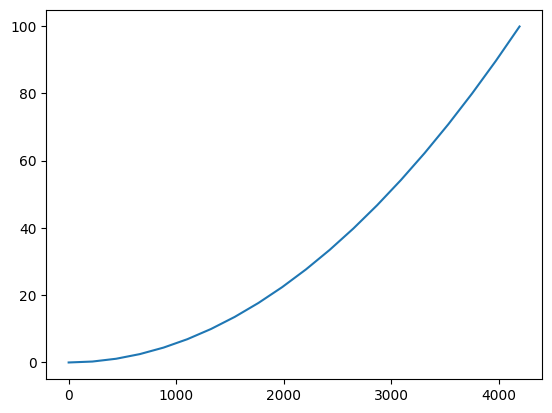

In [68]:
plt.plot(x0, z0)
plt.show()

In [69]:
q0=np.zeros(12*N)

In [70]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [71]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))

    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T + C0.squeeze())

    A0 = Jrho(RET,Jrho0)
    A1 = Π(φ,θ,ψ)
    A=np.einsum('ijk,ikr->ijr', A0, A1)

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = me(φ, θ, ψ, φ, θ, ψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    

    
    H = np.cross(w_e(φ,θ,ψ,dφ,dθ,dψ),np.einsum('ijk,ik->ij', A0, w_e(φ,θ,ψ,dφ,dθ,dψ)))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A, C + D + G - H - np.einsum('ijk,ik->ij',A, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [72]:
root_ = root(static_func, q0, method='df-sane')

In [73]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 3.765e+02  3.765e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.245e+03  2.466e+03 ...  0.000e+00  0.000e+00]
     nit: 390
    nfev: 1000
  method: df-sane

In [74]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [75]:
# q0 = root_.x

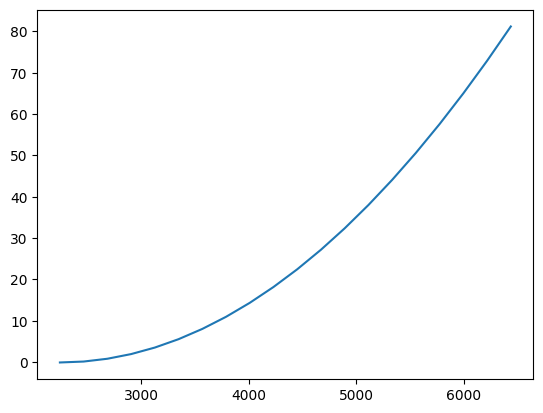

In [76]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [77]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [78]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [79]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [80]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [81]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [82]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [83]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [84]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [85]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [86]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.28174031e-08,  1.65584879e-08,  2.13414751e-07],
       [-1.33644789e-07, -9.33138153e-08,  2.71124009e-07],
       [ 3.65078449e-07,  6.39694714e-09, -1.96239853e-07],
       [-2.81259418e-07, -1.89471393e-07, -2.43453542e-08],
       [-1.63912773e-07,  1.74215529e-07,  9.34232958e-08],
       [ 3.27825546e-07,  1.08988388e-07, -2.01398507e-08],
       [ 3.35276127e-08,  2.53245384e-07, -1.10070687e-07],
       [ 9.68575478e-08,  2.54985935e-08,  1.78581104e-07],
       [ 5.96046448e-08, -5.41404006e-08, -4.74974513e-08],
       [-4.17232513e-07,  2.52657628e-08, -8.66129994e-08],
       [ 5.66244125e-07,  6.06632962e-08,  1.25961378e-07],
       [-4.76837158e-07,  2.43016984e-09,  2.88709998e-08],
       [ 5.96046448e-08, -2.03726813e-10,  1.45286322e-07],
       [ 4.76837158e-07,  3.27418093e-10,  1.67638063e-08],
       [-4.05063079e-07,  4.48343799e-09, -6.95286359e-09],
       [ 2.10157877e-07, -3.66497003e-10

### Vessle Simulation

In [87]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [88]:
Number*sampleTime

100.0

In [89]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [90]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [91]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

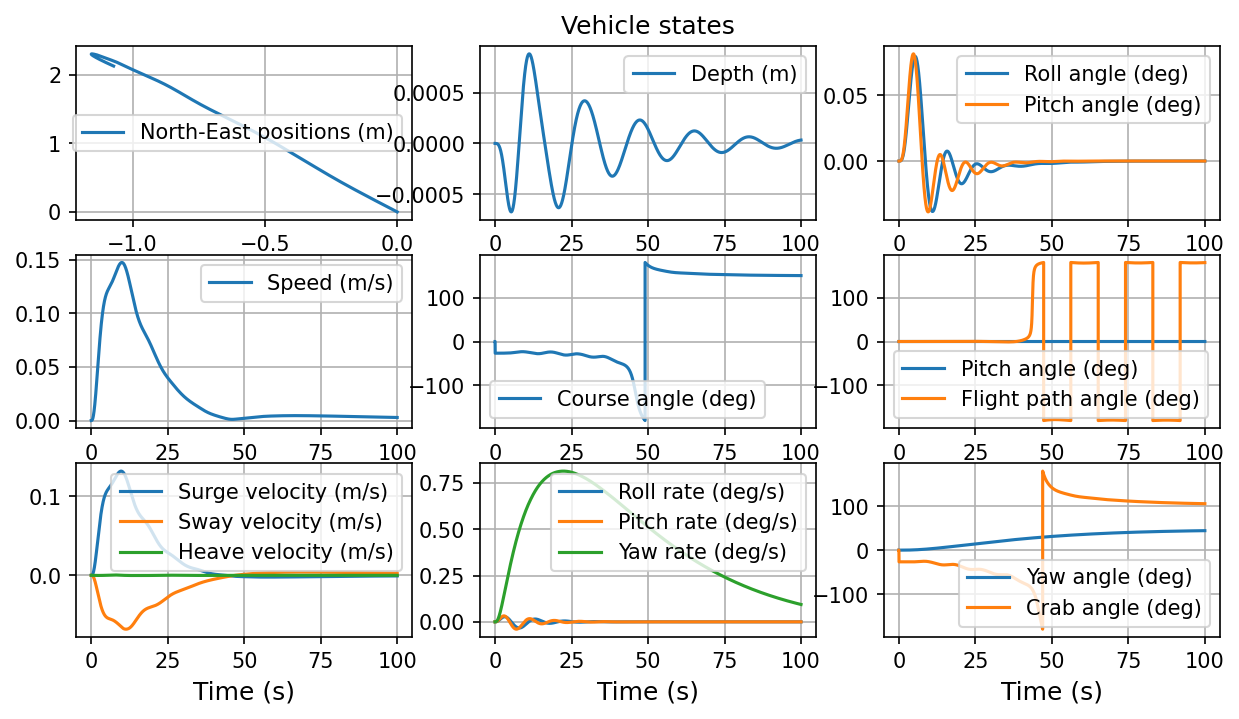

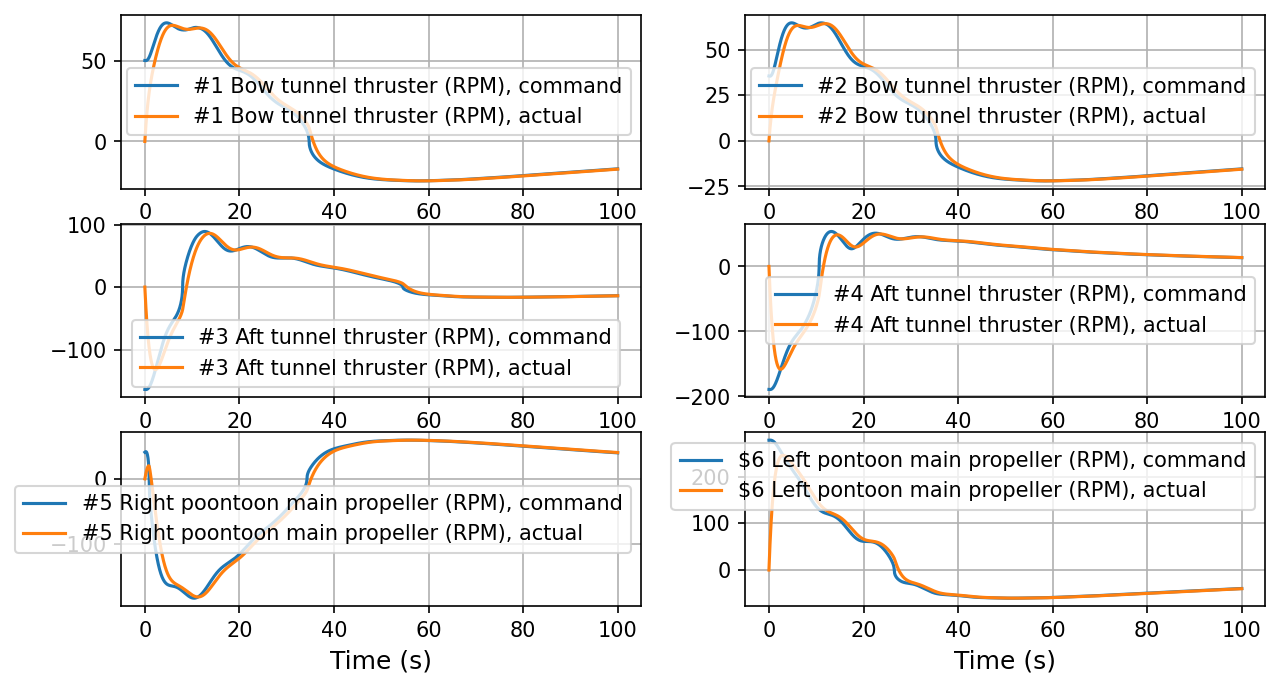

In [92]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [93]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

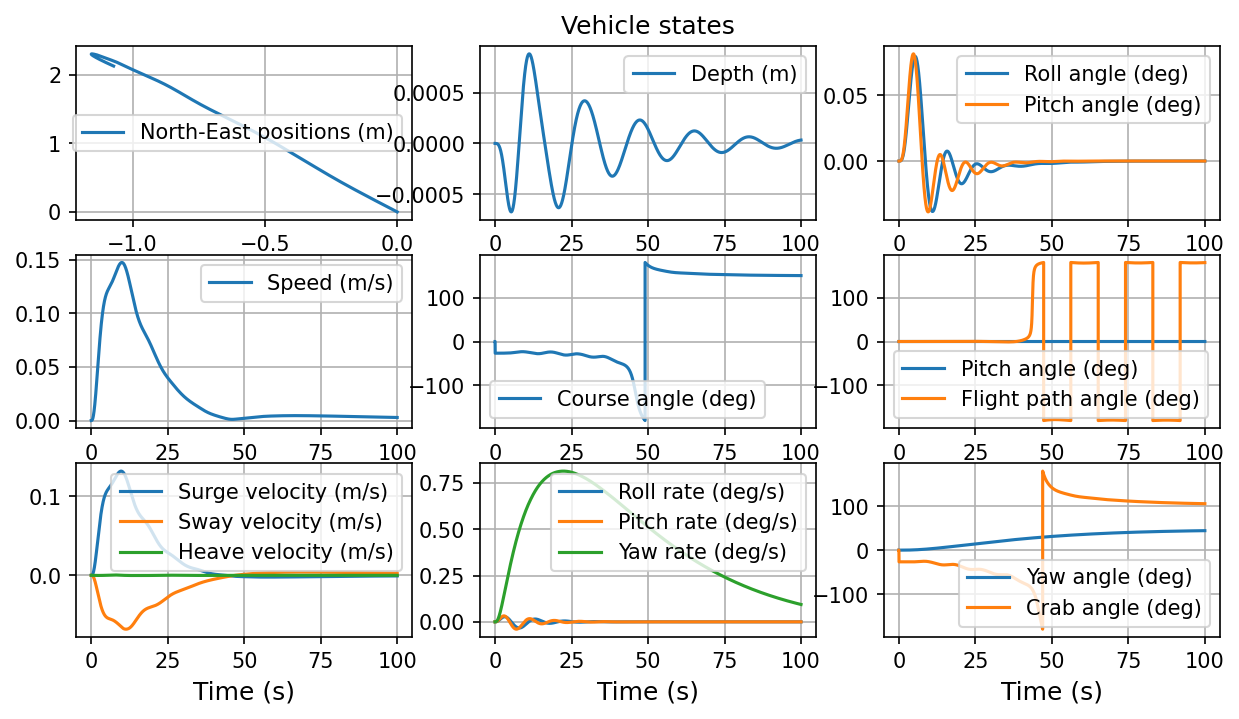

In [94]:
plotVehicleStates(simTime, simData, 3)

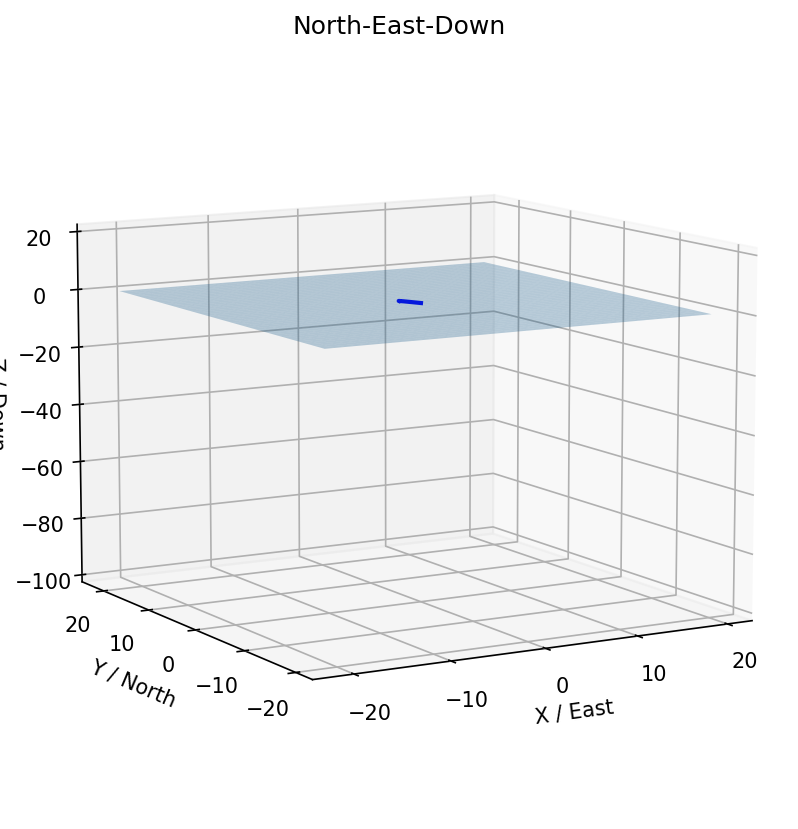

In [95]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [96]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [97]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.vx=0
        self.vy=0
        self.vz=0

### Dynamics

In [116]:
def dynamic_func(t, Q, coefs, T):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
    
    Z0 = fors
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), mom).squeeze()

    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T + C0.squeeze())

    A0 = Jrho(RET,Jrho0)
    A1 = Π(φ,θ,ψ)
    A=np.einsum('ijk,ikr->ijr', A0, A1)

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = me(φ, θ, ψ, φ, θ, ψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    

    
    H = np.cross(w_e(φ,θ,ψ,dφ,dθ,dψ),np.einsum('ijk,ik->ij', A0, w_e(φ,θ,ψ,dφ,dθ,dψ)))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A, C + D + G - H - np.einsum('ijk,ik->ij',A, B)).T
#############################################
    T.my_t=t
    T.vx=u_ve
    T.vy=v_ve
    T.vz=-w_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
    
    
    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [117]:
# integration parameters
tspan = (0., 5)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

In [ ]:
startTime1 = datetime.now()
us=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  3.690890874560425e-08  Iteration wall clock time:  0:00:01.056769


### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-70)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
us.shape

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()